In [48]:
%matplotlib inline
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
try: 
    import vocab
except ImportError:
    import sys
    sys.path.insert(0, '/Users/mbaumer/side_projects/ruth-bader-ginsbot/python/')
    import vocab
import keras

In [21]:
data = pd.read_csv('../data/supreme_court_dialogs_corpus_v1.01/supreme.conversations.txt',sep='\ \+\+\+\$\+\+\+\ ',
            names=['case_id','utterance_id','after_previous','speaker','isJustice','justice_vote','presenting_side','utterance'])

/Users/mbaumer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [22]:
data['justice_vote'][0]

'PETITIONER'

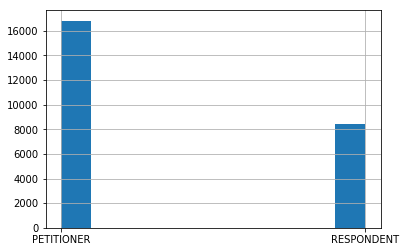

In [23]:
justice_lines = data[(data['isJustice'] == 'JUSTICE') & ((data['justice_vote'] == 'PETITIONER') | (data['justice_vote'] == 'RESPONDENT'))]
justice_lines['justice_vote'].hist()

(array([1.9791e+04, 3.9040e+03, 1.1020e+03, 2.9100e+02, 1.1600e+02,
        3.9000e+01, 1.5000e+01, 8.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  2. ,  53.9, 105.8, 157.7, 209.6, 261.5, 313.4, 365.3, 417.2,
        469.1, 521. ]),
 <a list of 10 Patch objects>)

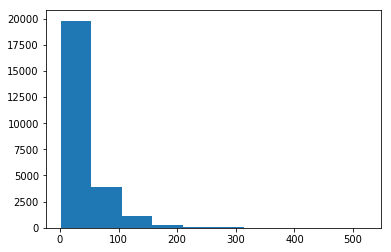

In [33]:
tokens = map(nltk.word_tokenize,justice_lines['utterance'])
plt.hist(map(len,tokens))

In [18]:
max_utterance_length = 200

In [34]:
len(tokens)

25273

In [32]:
len(justice_lines['justice_vote'])

25273

In [35]:
emb_matrix, word2id, id2word = vocab.get_glove('/Users/mbaumer/side_projects/ruth-bader-ginsbot/data/glove/glove.6B.50d.txt',50)

  2%|▏         | 8058/400000 [00:00<00:09, 40282.16it/s]

Loading GLoVE vectors from file: /Users/mbaumer/side_projects/ruth-bader-ginsbot/data/glove/glove.6B.50d.txt


100%|██████████| 400000/400000 [00:09<00:00, 43754.82it/s]


In [42]:
N_words = 0
N_unk = 0
list_list_tokens = []
for sentence in tokens:
    list_tokens = []
    for word in sentence:
        N_words += 1
        token_id = word2id.get(word,1)
        list_tokens.append(token_id)
        if token_id == 1:
            N_unk += 1
    list_list_tokens.append(list_tokens)
print 'Nwords:', N_words
print 'Nunk:', N_unk
print '%unk:', N_unk/N_words*100

Nwords: 904359
Nunk: 85233
%unk: 9.42468643536


In [43]:
list_list_tokens[0]

[1, 45, 116, 2273, 4021, 8, 2, 1, 1, 100, 1, 7, 1, 100, 2, 1, 1, 4, 1, 1, 4]

In [47]:
tokens[0]

['We',
 'will',
 'now',
 'hear',
 'argument',
 'in',
 'the',
 'Cherokee',
 'Nation',
 'against',
 'Thompson',
 'and',
 'Thompson',
 'against',
 'the',
 'Cherokee',
 'Nation',
 '.',
 'Mr.',
 'Miller',
 '.']

In [51]:
y = np.zeros(len(justice_lines))
y[np.where(justice_lines['justice_vote'] == 'PETITIONER')] = 1

In [66]:
train_inds = np.random.permutation(np.arange(len(justice_lines),dtype=int))[:int(len(justice_lines)*.7)]
test_inds = np.random.permutation(np.arange(len(justice_lines),dtype=int))[int(len(justice_lines)*.7):]

In [74]:
max(list_list_tokens)

[105528, 4]

In [77]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = len(word2id)
maxlen = 200
batch_size = 128

print('Loading data...')
x_train = [list_list_tokens[train_ind] for train_ind in train_inds]
y_train = y[train_inds]
x_test = [list_list_tokens[test_ind] for test_ind in test_inds]
y_test = y[test_inds]
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
17691 train sequences
7582 test sequences
Pad sequences (samples x time)
x_train shape: (17691, 200)
x_test shape: (7582, 200)
Build model...
Train...
Train on 17691 samples, validate on 7582 samples
Epoch 1/2
17691/17691 [==============================] - 386s 22ms/step - loss: 0.6381 - acc: 0.6650 - val_loss: 0.6201 - val_acc: 0.6717
Epoch 2/2
7582/7582 [==============================] - 21s 3ms/step
Test score: 0.5451745515572808
Test accuracy: 0.7309417041144878


In [80]:
from sklearn.metrics import roc_curve

In [79]:
y_pred = model.predict(x_train)

In [87]:
fpr,tpr, _ = roc_curve(y_train,y_pred)
fpr1,tpr1, _ = roc_curve(y_train,np.ones_like(y_train))

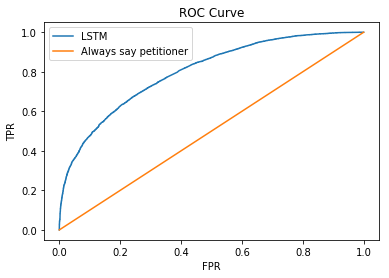

In [89]:
plt.plot(fpr,tpr,label='LSTM')
plt.plot(fpr1,tpr1,label='Always say petitioner')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

In [86]:
print ('Results from always saying Petitioner:',np.sum(y)/len(y))

Results from always saying Petitioner: 0.6650575713211728


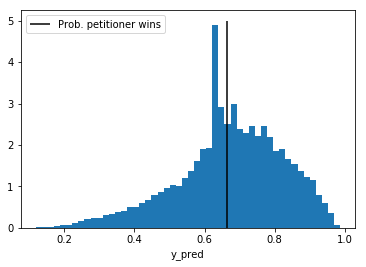

In [101]:
plt.hist(y_pred,normed=True,bins=50)
plt.xlabel('y_pred');
plt.vlines(np.sum(y)/len(y),0,5,label='Prob. petitioner wins')
plt.legend()